Affiliations between authors and journals in the 2-mode [NASA Astrophysics Data Systems](https://ui.adsabs.harvard.edu/) dataset. 

Find small sub-networks of important authors that are frequently collaborating together. In doing so we can also see which journals stand out as focal points for these types of collaborations.

In [44]:
import networkx as nx
import os
import ads as ads 
import json as json
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite as bi
from networkx.readwrite import json_graph

In [3]:
os.environ["ADS_DEV_KEY"] = "kNUoTurJ5TXV9hsw9KQN1k8wH4U0D7Oy0CJoOvyw"

In [4]:
ads.config.token = 'ADS_DEV_KEY' 

In [5]:
#Search for papers (200 most cited) on asteroseismology
papers1 = list(ads.SearchQuery(q= "asteroseismology", sort="citation_count", max_pages=4 ))

In [6]:
# find author names
a = []
for i in papers1:
    authors1 = i.author
    a.append(authors1)
author_names = a

//anaconda/lib/python3.5/site-packages/ads/utils.py:23: UserWarning: You are lazy loading attributes via 'author', and so are making multiple calls to the API. This will impact your overall rate limits.
  UserWarning,


In [7]:
# find the journals
j = []
for i in papers1:
    journals1 = i.pub
    j.append(journals1)
journals = j

//anaconda/lib/python3.5/site-packages/ads/utils.py:23: UserWarning: You are lazy loading attributes via 'pub', and so are making multiple calls to the API. This will impact your overall rate limits.
  UserWarning,


In [8]:
# create an initial df
df = pd.DataFrame({'Author_Names' : author_names,
 'Journal':journals
  })

In [9]:
# Expand the df with melt
s1 = df.apply(lambda x: pd.Series(x['Author_Names']),axis=1).stack().reset_index(level=1, drop=True)
s1.name = 'Author_Name'
df_m = df.drop('Author_Names', axis=1).join(s1)
df_m.head()

,Journal,Author_Name
0,Annual Review of Astronomy and Astrophysics,"Asplund, Martin"
0,Annual Review of Astronomy and Astrophysics,"Grevesse, Nicolas"
0,Annual Review of Astronomy and Astrophysics,"Sauval, A. Jacques"
0,Annual Review of Astronomy and Astrophysics,"Scott, Pat"
1,Solar Physics,"Scherrer, P. H."


In [10]:
df_m.Journal.unique()

array(['Annual Review of Astronomy and Astrophysics', 'Solar Physics',
       'Cosmic Abundances as Records of Stellar Evolution and Nucleosynthesis',
       'Instrumentation in Astronomy VIII',
       'Communications in Asteroseismology',
       'Monthly Notices of the Royal Astronomical Society',
       'The Astrophysical Journal',
       'Astronomy and Astrophysics Supplement Series',
       'Publications of the Astronomical Society of the Pacific',
       'Living Reviews in Relativity',
       'The Astrophysical Journal Supplement Series',
       'Astronomy and Astrophysics', 'Astronomy and Astrophysics Review',
       'Classical and Quantum Gravity', 'Physics Reports',
       'The Astronomical Journal', 'Nature', 'ArXiv e-prints',
       'Reviews of Modern Physics', None, 'Space Science Reviews',
       'Acta Astronomica', 'Astrophysics and Space Science',
       'Experimental Astronomy', 'Icarus', 'Science',
       'Annual Review of Nuclear and Particle Science',
       'Proceedi

In [11]:
author_nodes = pd.DataFrame(df_m.Author_Name.unique(),columns=['Author_Name'])
author_nodes['node_type'] = 'Author_Name'
journal_nodes = pd.DataFrame(df_m.Journal.unique(), columns=['Journal'])
journal_nodes['node_type'] = 'Journal'

In [12]:
# Build the graph from the node sets and edges
# set bipartite attribute to ensure weighted projection will work
a_nodes = list(author_nodes['Author_Name'])
j_nodes = list(journal_nodes['Journal'])
edge_bunch = [tuple(i) for i in df_m.values]

g = nx.Graph()
g.add_nodes_from(a_nodes,node_type='Author_Name', bipartite=0)
g.add_nodes_from(j_nodes,node_type='Journal', bipartite=1)
g.add_edges_from(edge_bunch)

In [14]:
# find the largest most connected graph
big_subg = [i for i in nx.connected_component_subgraphs(g) if len(i) > 200]
sg_largest = big_subg[0]

In [15]:
# weighted_projections can be applied to this subgraph to separate the two components
Journals,Author_Names = bi.sets(sg_largest)  # split into bipartites

In [16]:
j_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Journals) 

In [17]:
a_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Author_Names)

In [18]:
# Island Method 
j = j_proj_sg_largest.edges(data=True) 
a = a_proj_sg_largest.edges(data=True)

In [19]:
# With a min threshold of edge weight = 1, find the nodes with strong relationships within the sub-graphs -SNAS Ch. 4
def trim(g, weight):
    g_temp = nx.Graph()
    edge_bunch2 = [i for i in g.edges(data=True) if i[2]['weight'] > weight]    
    g_temp.add_edges_from(edge_bunch2)
    return g_temp

In [20]:
a_sg_island =  trim(a_proj_sg_largest, 1)
j_sg_island = trim(j_proj_sg_largest,1)

In [21]:
# We now have two islands of the projected authors and journals. 
# degree centrality will help show which nodes are the key to the networks.
a_degree = nx.degree_centrality(a_sg_island)
j_degree = nx.degree_centrality(j_sg_island)
pd.DataFrame.from_dict(a_degree,orient='index').sort_values(0,ascending=False)

,0
The Astrophysical Journal,0.764706
The Astrophysical Journal Supplement Series,0.588235
Astronomy and Astrophysics,0.529412
Science,0.529412
Experimental Astronomy,0.470588
Publications of the Astronomical Society of the Pacific,0.411765
Nature,0.411765
Monthly Notices of the Royal Astronomical Society,0.352941
The Astronomical Journal,0.352941
Annual Review of Astronomy and Astrophysics,0.294118


In [22]:
pd.DataFrame.from_dict(j_degree,orient='index').sort_values(0,ascending=False).head()

,0
"García, R. A.",0.784946
"Appourchaux, T.",0.774194
"Miglio, A.",0.774194
"Mathur, S.",0.774194
"Christensen-Dalsgaard, J.",0.774194


In [23]:
# examine the connected subgraphs of islands
j_connected = [i for i in nx.connected_component_subgraphs(j_proj_sg_largest) if len(i) > 1]
a_connected = [i for i in nx.connected_component_subgraphs(a_proj_sg_largest) if len(i) > 1]

In [24]:
print ("Author Components:", [len(i) for i in a_connected]) 
print ("Journal Components:", [len(i) for i in j_connected]) 

Author Components: [31]
Journal Components: [1648]


In [25]:
# combining the graphs 
def merge_graph(connected_g):
    g = nx.Graph()
    for h in connected_g:
        g = nx.compose(g,h)
    return g

a_islands = merge_graph(a_connected)
j_islands = merge_graph(j_connected)

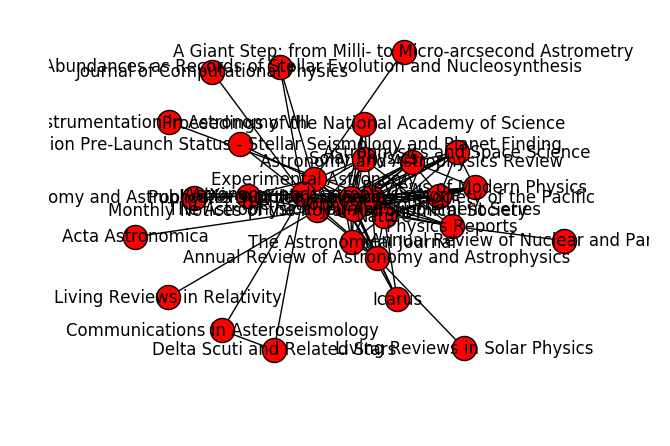

In [27]:
%matplotlib inline 
#ugly plots
nx.draw(a_islands, with_labels=True)

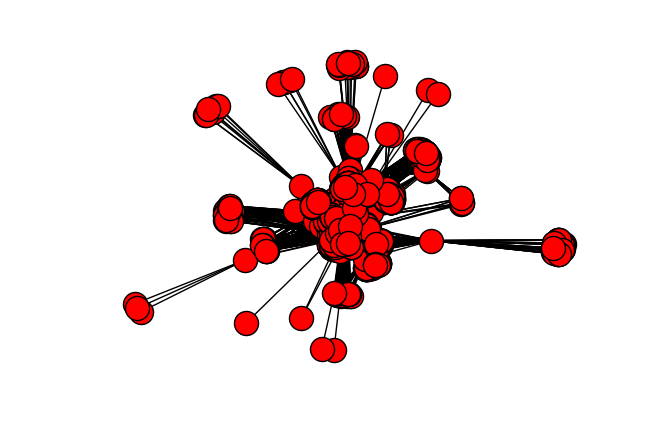

In [28]:
nx.draw(j_islands, with_labels=False) # Extra not useful graph

In [41]:
# creating json data
j_json_data = json_graph.node_link_data(j_islands)
a_json_data = json_graph.node_link_data(a_islands)

In [55]:
a_json_data

{'directed': False,
 'graph': {'name': 'compose( ,  )'},
 'links': [{'source': 0, 'target': 15, 'weight': 1},
  {'source': 18, 'target': 4, 'weight': 2},
  {'source': 18, 'target': 8, 'weight': 2},
  {'source': 18, 'target': 19, 'weight': 2},
  {'source': 18, 'target': 7, 'weight': 1},
  {'source': 18, 'target': 20, 'weight': 4},
  {'source': 18, 'target': 15, 'weight': 1},
  {'source': 18, 'target': 24, 'weight': 1},
  {'source': 1, 'target': 20, 'weight': 1},
  {'source': 1, 'target': 29, 'weight': 1},
  {'source': 20, 'target': 25, 'weight': 1},
  {'source': 20, 'target': 30, 'weight': 12},
  {'source': 20, 'target': 3, 'weight': 4},
  {'source': 20, 'target': 28, 'weight': 1},
  {'source': 20, 'target': 21, 'weight': 1},
  {'source': 20, 'target': 4, 'weight': 34},
  {'source': 20, 'target': 22, 'weight': 1},
  {'source': 20, 'target': 29, 'weight': 1},
  {'source': 20, 'target': 19, 'weight': 30},
  {'source': 20, 'target': 7, 'weight': 17},
  {'source': 20, 'target': 23, 'weight'

In [50]:
# write the files
# a_islands
with open('a_json_data.json', 'w') as outfile1:
    outfile1.write(json.dumps(json_graph.node_link_data(a_islands)))
# j_islands
with open('j_json_data.json', 'w') as outfile1:
    outfile1.write(json.dumps(json_graph.node_link_data(j_islands)))

In [57]:
# I want to add to the nodes:
# "x": 0,
# "y": 0,
# "size": 3  
# "centrality": 

# Try adding x
with open('a_json_data.json') as json_file:
    json_data = json.load(json_file)
links = json_data['links']
for link in links:
    links['x'] = '0'
with tempfile.NamedTemporaryFile(dir='.', delete=False) as temp_file:
    json.dump(temp_file, json_data)
os.replace(temp_file.name, 'a_json_data.json')


TypeError: list indices must be integers or slices, not str